In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws
from scripts.utils.calculate_index import format_df, calculate_index, weight_domains
from scripts.utils.index_plot import index_plot, index_domain_plot

In [2]:
# pull csv from aws
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data'
output_folder = 'aws_csvs'

pull_csv_from_directory(bucket_name, aws_dir, output_folder, search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data.


In [3]:
built_domain = pd.read_csv(r'aws_csvs/built_domain_index_calculation.csv')
governance_domain = pd.read_csv(r'aws_csvs/governance_domain_index_calculation.csv')
natural_domain = pd.read_csv(r'aws_csvs/natural_domain_index_calculation.csv')
society_domain = pd.read_csv(r'aws_csvs/society_economy_domain_index_calculation.csv')
climate_domain = pd.read_csv(r'aws_csvs/climate_domain_index_calculation.csv')

In [4]:
# Keep only the first two columns
built_domain_cleaned = built_domain.iloc[:, :2]
governance_domain_cleaned = governance_domain.iloc[:, :2]
natural_domain_cleaned = natural_domain.iloc[:, :2]
society_domain_cleaned = society_domain.iloc[:, :2]
climate_domain_cleaned = climate_domain.iloc[:, :2]

Next, we'll read in the synthetic climate indicator data as well, so we can calculate the Index across California. 

In [5]:
merged_domains = pd.merge(governance_domain_cleaned, built_domain_cleaned, on='GEOID', how='left')
merged_domains = pd.merge(merged_domains, natural_domain_cleaned, on='GEOID', how='left')
merged_domains = pd.merge(merged_domains, society_domain_cleaned, on='GEOID', how='left')

In [6]:
# Ensure all values in GEOID are strings
merged_domains['GEOID'] = merged_domains['GEOID'].astype(str)

# Add a '0' to the beginning of each GEOID and pad them to the correct length
merged_domains['GEOID'] = merged_domains['GEOID'].str.zfill(merged_domains['GEOID'].str.len().max() + 1)

# Rename the standardized columns for simplicity
merged_domains = merged_domains.rename(columns={
    'summed_indicators_governance_domain_min_max_standardized':'governance_domain_index',
    'summed_indicators_built_domain_min_max_standardized':'built_domain_index',
    'summed_indicators_natural_domain_min_max_standardized':'natural_systems_domain_index', 
    'summed_indicators_society_economy_domain_min_max_standardized':'society_economy_domain_index'     
 
})

# Display the dataframe
merged_domains

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index
0,06001400100,0.657823,0.701072,0.706555,0.704602
1,06001400200,0.657823,0.754271,0.454009,0.695877
2,06001400300,0.657823,0.750204,0.854000,0.746512
3,06001400400,0.657823,0.758585,0.837761,0.770337
4,06001400500,0.657823,0.754902,0.829855,0.796901
...,...,...,...,...,...
9124,06115040902,0.638738,0.841605,0.744915,0.698060
9125,06115041001,0.638738,0.895790,0.749494,0.740463
9126,06115041002,0.638738,0.879166,0.652535,0.715148
9127,06115041101,0.638738,0.921867,0.571603,0.747091


In [7]:
all_domains = merged_domains.copy()
all_domains['built_median'] = merged_domains['built_domain_index'].median()
all_domains['natural_systems_median'] = merged_domains['natural_systems_domain_index'].median()
all_domains['society_economy_median'] = merged_domains['society_economy_domain_index'].median()

all_domains

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median
0,06001400100,0.657823,0.701072,0.706555,0.704602,0.662419,0.714087,0.769649
1,06001400200,0.657823,0.754271,0.454009,0.695877,0.662419,0.714087,0.769649
2,06001400300,0.657823,0.750204,0.854000,0.746512,0.662419,0.714087,0.769649
3,06001400400,0.657823,0.758585,0.837761,0.770337,0.662419,0.714087,0.769649
4,06001400500,0.657823,0.754902,0.829855,0.796901,0.662419,0.714087,0.769649
...,...,...,...,...,...,...,...,...
9124,06115040902,0.638738,0.841605,0.744915,0.698060,0.662419,0.714087,0.769649
9125,06115041001,0.638738,0.895790,0.749494,0.740463,0.662419,0.714087,0.769649
9126,06115041002,0.638738,0.879166,0.652535,0.715148,0.662419,0.714087,0.769649
9127,06115041101,0.638738,0.921867,0.571603,0.747091,0.662419,0.714087,0.769649


In [8]:
def calculate_adjusted_value(row, category):
    category_median_col = f'{category}_median'
    category_col = f'{category}_domain_index'
    adjusted_col = f'{category}_tract_adjusted'
    return (row[category_col] - row[category_median_col]) / row[category_median_col]

# Loop through each row and calculate the adjusted value for each category
for index, row in all_domains.iterrows():
    for category in ['natural_systems', 'society_economy', 'built']:
        adjusted_value = calculate_adjusted_value(row, category)
        adjusted_col = f'{category}_tract_adjusted'
        all_domains.at[index, adjusted_col] = adjusted_value

# Display the DataFrame
all_domains

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted
0,06001400100,0.657823,0.701072,0.706555,0.704602,0.662419,0.714087,0.769649,-0.010547,-0.084515,0.058352
1,06001400200,0.657823,0.754271,0.454009,0.695877,0.662419,0.714087,0.769649,-0.364211,-0.095851,0.138661
2,06001400300,0.657823,0.750204,0.854000,0.746512,0.662419,0.714087,0.769649,0.195933,-0.030062,0.132523
3,06001400400,0.657823,0.758585,0.837761,0.770337,0.662419,0.714087,0.769649,0.173191,0.000895,0.145175
4,06001400500,0.657823,0.754902,0.829855,0.796901,0.662419,0.714087,0.769649,0.162121,0.035409,0.139614
...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.638738,0.841605,0.744915,0.698060,0.662419,0.714087,0.769649,0.043171,-0.093015,0.270502
9125,06115041001,0.638738,0.895790,0.749494,0.740463,0.662419,0.714087,0.769649,0.049584,-0.037922,0.352302
9126,06115041002,0.638738,0.879166,0.652535,0.715148,0.662419,0.714087,0.769649,-0.086197,-0.070813,0.327205
9127,06115041101,0.638738,0.921867,0.571603,0.747091,0.662419,0.714087,0.769649,-0.199533,-0.029309,0.391667


In [9]:
def calcrai_calculation_numerator(df, society_weight, built_weight, natural_weight):    
    # Loop through each row and calculate calcrai_numerator
    for index, row in df.iterrows():
        governance_col = 'governance_domain_index'
        society_adjusted_col = 'society_economy_tract_adjusted'
        built_adjusted_col = 'built_tract_adjusted'
        natural_adjusted_col = 'natural_systems_tract_adjusted'
        
        calcrai_numerator = (
            row[governance_col] +
            (society_weight * (row[society_adjusted_col]) * row[governance_col]) +
            (built_weight * (row[built_adjusted_col]) * row[governance_col]) +
            (natural_weight * (row[natural_adjusted_col]) * row[governance_col])
        )
        df.at[index, 'calcrai_numerator'] = calcrai_numerator
        df

calcrai_numerator = all_domains.copy()

calcrai_calculation_numerator(calcrai_numerator, 1, 1, 1)

In [10]:
calcrai_numerator

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted,calcrai_numerator
0,06001400100,0.657823,0.701072,0.706555,0.704602,0.662419,0.714087,0.769649,-0.010547,-0.084515,0.058352,0.633674
1,06001400200,0.657823,0.754271,0.454009,0.695877,0.662419,0.714087,0.769649,-0.364211,-0.095851,0.138661,0.446398
2,06001400300,0.657823,0.750204,0.854000,0.746512,0.662419,0.714087,0.769649,0.195933,-0.030062,0.132523,0.854113
3,06001400400,0.657823,0.758585,0.837761,0.770337,0.662419,0.714087,0.769649,0.173191,0.000895,0.145175,0.867840
4,06001400500,0.657823,0.754902,0.829855,0.796901,0.662419,0.714087,0.769649,0.162121,0.035409,0.139614,0.879604
...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.638738,0.841605,0.744915,0.698060,0.662419,0.714087,0.769649,0.043171,-0.093015,0.270502,0.779680
9125,06115041001,0.638738,0.895790,0.749494,0.740463,0.662419,0.714087,0.769649,0.049584,-0.037922,0.352302,0.871215
9126,06115041002,0.638738,0.879166,0.652535,0.715148,0.662419,0.714087,0.769649,-0.086197,-0.070813,0.327205,0.747448
9127,06115041101,0.638738,0.921867,0.571603,0.747091,0.662419,0.714087,0.769649,-0.199533,-0.029309,0.391667,0.742740


Bring in Climate Data

In [11]:
climate_domain_cleaned

,GEOID,climate_risk_min_max_standardized
0,6001400100,0.247113
1,6001400200,0.225972
2,6001400300,0.225258
3,6001400400,0.216269
4,6001400500,0.212934
...,...,...
9124,6115040902,0.309647
9125,6115041001,0.361374
9126,6115041002,0.334189
9127,6115041101,0.408105


In [12]:
# Ensure all values in GEOID are strings
climate_domain_cleaned['GEOID'] = climate_domain_cleaned['GEOID'].astype(str)

# Add a '0' to the beginning of each GEOID and pad them to the correct length
climate_domain_cleaned['GEOID'] = climate_domain_cleaned['GEOID'].str.zfill(merged_domains['GEOID'].str.len().max())

# Display the dataframe
climate_domain_cleaned

,GEOID,climate_risk_min_max_standardized
0,06001400100,0.247113
1,06001400200,0.225972
2,06001400300,0.225258
3,06001400400,0.216269
4,06001400500,0.212934
...,...,...
9124,06115040902,0.309647
9125,06115041001,0.361374
9126,06115041002,0.334189
9127,06115041101,0.408105


In [13]:
calcrai_numerator['climate_risk'] = climate_domain[['climate_risk_min_max_standardized']]
calcrai_numerator

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted,calcrai_numerator,climate_risk
0,06001400100,0.657823,0.701072,0.706555,0.704602,0.662419,0.714087,0.769649,-0.010547,-0.084515,0.058352,0.633674,0.247113
1,06001400200,0.657823,0.754271,0.454009,0.695877,0.662419,0.714087,0.769649,-0.364211,-0.095851,0.138661,0.446398,0.225972
2,06001400300,0.657823,0.750204,0.854000,0.746512,0.662419,0.714087,0.769649,0.195933,-0.030062,0.132523,0.854113,0.225258
3,06001400400,0.657823,0.758585,0.837761,0.770337,0.662419,0.714087,0.769649,0.173191,0.000895,0.145175,0.867840,0.216269
4,06001400500,0.657823,0.754902,0.829855,0.796901,0.662419,0.714087,0.769649,0.162121,0.035409,0.139614,0.879604,0.212934
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.638738,0.841605,0.744915,0.698060,0.662419,0.714087,0.769649,0.043171,-0.093015,0.270502,0.779680,0.309647
9125,06115041001,0.638738,0.895790,0.749494,0.740463,0.662419,0.714087,0.769649,0.049584,-0.037922,0.352302,0.871215,0.361374
9126,06115041002,0.638738,0.879166,0.652535,0.715148,0.662419,0.714087,0.769649,-0.086197,-0.070813,0.327205,0.747448,0.334189
9127,06115041101,0.638738,0.921867,0.571603,0.747091,0.662419,0.714087,0.769649,-0.199533,-0.029309,0.391667,0.742740,0.408105


In [14]:
calcrai_index_calculation = calcrai_numerator.copy()
calcrai_index_calculation['calcrai_calculated'] = calcrai_numerator['calcrai_numerator'] / calcrai_numerator['climate_risk']

In [15]:
calcrai_index_calculation

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted,calcrai_numerator,climate_risk,calcrai_calculated
0,06001400100,0.657823,0.701072,0.706555,0.704602,0.662419,0.714087,0.769649,-0.010547,-0.084515,0.058352,0.633674,0.247113,2.564315
1,06001400200,0.657823,0.754271,0.454009,0.695877,0.662419,0.714087,0.769649,-0.364211,-0.095851,0.138661,0.446398,0.225972,1.975456
2,06001400300,0.657823,0.750204,0.854000,0.746512,0.662419,0.714087,0.769649,0.195933,-0.030062,0.132523,0.854113,0.225258,3.791708
3,06001400400,0.657823,0.758585,0.837761,0.770337,0.662419,0.714087,0.769649,0.173191,0.000895,0.145175,0.867840,0.216269,4.012780
4,06001400500,0.657823,0.754902,0.829855,0.796901,0.662419,0.714087,0.769649,0.162121,0.035409,0.139614,0.879604,0.212934,4.130875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.638738,0.841605,0.744915,0.698060,0.662419,0.714087,0.769649,0.043171,-0.093015,0.270502,0.779680,0.309647,2.517965
9125,06115041001,0.638738,0.895790,0.749494,0.740463,0.662419,0.714087,0.769649,0.049584,-0.037922,0.352302,0.871215,0.361374,2.410843
9126,06115041002,0.638738,0.879166,0.652535,0.715148,0.662419,0.714087,0.769649,-0.086197,-0.070813,0.327205,0.747448,0.334189,2.236603
9127,06115041101,0.638738,0.921867,0.571603,0.747091,0.662419,0.714087,0.769649,-0.199533,-0.029309,0.391667,0.742740,0.408105,1.819972


In [16]:
def weight_domains(df, society, built, natural):
    '''
    Calculates the weighting scheme, based on input parameters:
    society, built, and natural
    '''
    governance_col = 'governance_domain_index'
    society_adjusted_col = 'society_economy_tract_adjusted'
    built_adjusted_col = 'built_tract_adjusted'
    natural_adjusted_col = 'natural_systems_tract_adjusted' 

    weighting = (
        df[governance_col] + 
        (society * (df[society_adjusted_col] * df[governance_col])) +
        (built * (df[built_adjusted_col] * df[governance_col])) +
        (natural * (df[natural_adjusted_col] * df[governance_col]))
    )
 
    df['calcrai_weighted'] = weighting
    return df

def calculate_index(df):
    '''Calcutes the Cal-CRAI index'''
    
    df['calcrai_score'] = df['calcrai_weighted'] / df['climate_risk']

    # testing for 0 values --> divide error
    df.loc[df['climate_risk'] == 0, 'calcrai_score'] = 0
    
    return df

In [17]:
df_eq = weight_domains(calcrai_index_calculation, society=1, built=1, natural=1)
calcrai_index_equal_weight = calculate_index(df_eq)

In [18]:
calcrai_index_equal_weight

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted,calcrai_numerator,climate_risk,calcrai_calculated,calcrai_weighted,calcrai_score
0,06001400100,0.657823,0.701072,0.706555,0.704602,0.662419,0.714087,0.769649,-0.010547,-0.084515,0.058352,0.633674,0.247113,2.564315,0.633674,2.564315
1,06001400200,0.657823,0.754271,0.454009,0.695877,0.662419,0.714087,0.769649,-0.364211,-0.095851,0.138661,0.446398,0.225972,1.975456,0.446398,1.975456
2,06001400300,0.657823,0.750204,0.854000,0.746512,0.662419,0.714087,0.769649,0.195933,-0.030062,0.132523,0.854113,0.225258,3.791708,0.854113,3.791708
3,06001400400,0.657823,0.758585,0.837761,0.770337,0.662419,0.714087,0.769649,0.173191,0.000895,0.145175,0.867840,0.216269,4.012780,0.867840,4.012780
4,06001400500,0.657823,0.754902,0.829855,0.796901,0.662419,0.714087,0.769649,0.162121,0.035409,0.139614,0.879604,0.212934,4.130875,0.879604,4.130875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.638738,0.841605,0.744915,0.698060,0.662419,0.714087,0.769649,0.043171,-0.093015,0.270502,0.779680,0.309647,2.517965,0.779680,2.517965
9125,06115041001,0.638738,0.895790,0.749494,0.740463,0.662419,0.714087,0.769649,0.049584,-0.037922,0.352302,0.871215,0.361374,2.410843,0.871215,2.410843
9126,06115041002,0.638738,0.879166,0.652535,0.715148,0.662419,0.714087,0.769649,-0.086197,-0.070813,0.327205,0.747448,0.334189,2.236603,0.747448,2.236603
9127,06115041101,0.638738,0.921867,0.571603,0.747091,0.662419,0.714087,0.769649,-0.199533,-0.029309,0.391667,0.742740,0.408105,1.819972,0.742740,1.819972


In [19]:
calcrai_index_equal_weight.to_csv('calcrai_equal_weighted_index.csv', index=False)

In [20]:
# upload to aws bucket
bucket_name = 'ca-climate-index'
directory = '3_fair_data/index_data'
file = 'calcrai_equal_weighted_index.csv'

upload_csv_aws([file], bucket_name, directory)

calcrai_equal_weighted_index.csv uploaded to AWS


Let's print some results to see the range of values in the synthetic data. 

In [21]:
print('Min score / less resilience: ', calcrai_index_equal_weight['calcrai_score'].min())
print('Max score / more resilience: ', calcrai_index_equal_weight['calcrai_score'].max())
print('Mean score / average resilience: ', calcrai_index_equal_weight['calcrai_score'].mean())
print('Median score / median resilience: ', calcrai_index_equal_weight['calcrai_score'].median())

Min score / less resilience:  -0.11588239984624434
Max score / more resilience:  21.698081835821185
Mean score / average resilience:  2.4267581650095105
Median score / median resilience:  1.8987067043420536


Let's also see how many census tracts have high resilience scores. We'll be diving further into the relationship between various domains and the resulting `calcrai_score` value. For example, how do high governance scores coupled with low risk impact the Index value? 

In [22]:
# how many census tracts have resilience scores above 10*mean
print(len(calcrai_index_equal_weight.loc[calcrai_index_equal_weight['calcrai_score'] > (10*calcrai_index_equal_weight['calcrai_score'].mean())]))
calcrai_index_equal_weight.loc[df_eq['calcrai_score'] > (20*calcrai_index_equal_weight['calcrai_score'].mean())].head(5)

0


,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted,calcrai_numerator,climate_risk,calcrai_calculated,calcrai_weighted,calcrai_score


### Step 3: Visualize Results
Let's visualize the results! We'll also demonstrate the power of different customized weighting scenarios. 

In the cells below, we produce a map of the Cal-CRAI across California, as well as comparison maps of the input domains in order to provide context as to the relative importance of each domain in the final calculation. 

#### 3a) Equal Weighting of Domains
This is the "standard" version of the Cal-CRAI calculation -- where the input domains `Society & Economy`, `Built Environment`, and `Natural Systems` are equally weighted in importance. This ensures that we capture a baseline of conditions across California. 

**Note**: These maps are produced with *synthetic* data and do not represent the actual CalCRAI values per census tract. This "real" data is currently being calculated, and these maps will be updated!

In [23]:
census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
ca_boundaries = gpd.read_file(census_shp_dir)
ca_boundaries.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,085,504321,06085504321,5043.21,Census Tract 5043.21,G5020,S,1450237,0,+37.3931319,-121.8651427,"POLYGON ((-121.87556 37.39924, -121.87535 37.3..."
1,06,085,504410,06085504410,5044.10,Census Tract 5044.10,G5020,S,1102136,0,+37.4093719,-121.8788884,"POLYGON ((-121.88886 37.40758, -121.88576 37.4..."
2,06,085,507003,06085507003,5070.03,Census Tract 5070.03,G5020,S,9529865,0,+37.2199936,-121.9979512,"POLYGON ((-122.02489 37.21683, -122.02459 37.2..."
3,06,085,507004,06085507004,5070.04,Census Tract 5070.04,G5020,S,2424447,0,+37.2260144,-121.9763816,"POLYGON ((-121.99304 37.22562, -121.99249 37.2..."
4,06,085,502204,06085502204,5022.04,Census Tract 5022.04,G5020,S,331145,0,+37.3013832,-121.9258424,"POLYGON ((-121.93167 37.29803, -121.92801 37.3..."


In [24]:
def index_plot(df, scenario=None, save=False):
    '''Maps the Cal-CRAI index value for entire state'''

    # plotting help
    df2 = df.merge(ca_boundaries, on='GEOID')
    df2['geometry'] = df2['geometry']
    df2 = gpd.GeoDataFrame(df2, geometry='geometry', crs=4269)

    # set-up figure
    fig, ax = plt.subplots(1, 1, figsize=(4.5,6), layout='compressed')

    df2.plot(column='calcrai_score', ax=ax, vmin=-3, vmax=3, legend=True, cmap='RdYlBu',
                     legend_kwds={'label':'Cal-CRAI Index value', 'orientation': 'horizontal', 'shrink':0.7});

    if scenario == None:
        plt.annotate('Equal-weighted domains'.format(scenario), xy=(0.02, 0.02), xycoords='axes fraction')
    if scenario != None:
        plt.annotate('Weighting for {}'.format(scenario), xy=(0.02, 0.02), xycoords='axes fraction')

    if save:
        fig.savefig('equal_weight_calcrai_score.png', dpi=300, bbox_inches='tight') ## need to replace fig name once data repo completed

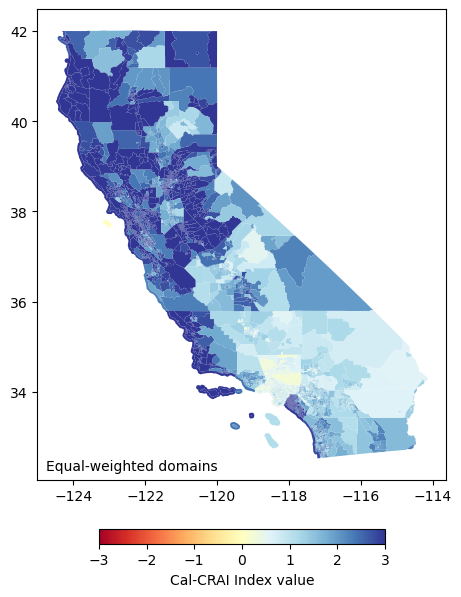

In [25]:
index_plot(calcrai_index_equal_weight)

To interpret these maps, a **positive** value indicates a high resilience score, while a **negative** value indicates a low resilience score. 

Now let's look at the input domains as well: 

In [58]:
def _domain_plot_weighting(df, society, built, natural):
    '''In order to visualize the importance of weighting each domain'''
    df['society_economy_tract_adjusted'] = df['society_economy_tract_adjusted'] * society
    df['built_tract_adjusted'] = df['built_tract_adjusted'] * built
    df['natural_tract_adjusted'] = df['natural_tract_adjusted'] * natural
    return df

def index_domain_plot(df, scenario=None, society=1, built=1, natural=1, save=False):
    '''Produces subplots of the Cal-CRAI index value and the corresponding domains'''
    # internally weight domains
    df = _domain_plot_weighting(df, society, built, natural)
    
    # plotting help
    df2 = df.merge(ca_boundaries, on='GEOID')
    df2 = gpd.GeoDataFrame(df2, geometry='geometry', crs=4269)

    # set-up figure
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(12,6), layout='compressed')
    vmin=-3
    vmax=3
    dmin=-1
    dmax=1
    cm='RdYlBu'

    df2.plot(ax=ax1, column='calcrai_score', vmin=vmin, vmax=vmax, legend=True, cmap=cm,
             legend_kwds={'label':'Cal-CRAI Index value', 'orientation': 'horizontal', 'shrink':0.7});
    df2.plot(ax=ax2, column='society_economy_tract_adjusted', vmin=dmin, vmax=dmax, legend=True, cmap=cm,
             legend_kwds={'label':'Society & Economy \ndomain weight', 'orientation': 'horizontal', 'shrink':0.7});
    df2.plot(ax=ax3, column='natural_tract_adjusted', vmin=dmin, vmax=dmax, legend=True, cmap=cm,
             legend_kwds={'label':'Natural Systems \ndomain weight', 'orientation': 'horizontal', 'shrink':0.7});
    df2.plot(ax=ax4, column='built_tract_adjusted', vmin=dmin, vmax=dmax, legend=True, cmap=cm,
             legend_kwds={'label':'Built Environment \ndomain weight', 'orientation': 'horizontal', 'shrink':0.7});

    if scenario == None:
        ax1.annotate('Equal-weighted domains'.format(scenario), xy=(0.02, 0.02), xycoords='axes fraction')
    else: 
        ax1.annotate('Weighting for {}'.format(scenario), xy=(0.02, 0.02), xycoords='axes fraction')

    if save:
        fig.savefig('ca_domains_map.png', dpi=300, bbox_inches='tight') ## need to replace fig name once data repo completed

In [ ]:
calcrai_index_equal_weight

In [ ]:
index_domain_plot(calcrai_index_equal_weight)